We start, as normal, by creating a `Gobnilp` object to work with:

In [1]:
from gobnilp import Gobnilp
m = Gobnilp()

Academic license - for non-commercial use only


Now we will create 'local scores' from the built-in `alarm_10000.dat` dataset:

In [2]:
m.input_discrete_data('alarm_10000.dat')
local_scores_dict = m.return_local_scores()

The computation of these local scores is not immediate, but should not take too long. Since `return_local_scores` was called with no arguments, `Gobnilp`'s default BDeu score will be used. `return_local_scores` is unusual for a `Gobnilp` method since it returns a value: a dictionary of local scores. The keys of this dictionary are the BN variables (the names of these variables are given on the first line of `alarm_10000.dat`). 

In [3]:
print(local_scores_dict.keys())

dict_keys(['ANAPHYLAXIS', 'ARTCO2', 'BP', 'CATECHOL', 'CO', 'CVP', 'DISCONNECT', 'ERRCAUTER', 'ERRLOWOUTPUT', 'EXPCO2', 'FIO2', 'HISTORY', 'HR', 'HRBP', 'HREKG', 'HRSAT', 'HYPOVOLEMIA', 'INSUFFANESTH', 'INTUBATION', 'KINKEDTUBE', 'LVEDVOLUME', 'LVFAILURE', 'MINVOL', 'MINVOLSET', 'PAP', 'PCWP', 'PRESS', 'PULMEMBOLUS', 'PVSAT', 'SAO2', 'SHUNT', 'STROKEVOLUME', 'TPR', 'VENTALV', 'VENTLUNG', 'VENTMACH', 'VENTTUBE'])


The value associated with each BN variable is a dictionary mapping potential parent sets for that variable to a local score - which states, intuitively, how good it would be for that parent set to be selected. We find that there is variation in the number of parent sets stored:

In [4]:
for child, scored_parentsets in local_scores_dict.items():
    print(child, len(scored_parentsets))

ANAPHYLAXIS 5
ARTCO2 473
BP 266
CATECHOL 383
CO 469
CVP 32
DISCONNECT 127
ERRCAUTER 22
ERRLOWOUTPUT 14
EXPCO2 176
FIO2 18
HISTORY 36
HR 154
HRBP 135
HREKG 122
HRSAT 122
HYPOVOLEMIA 57
INSUFFANESTH 1
INTUBATION 211
KINKEDTUBE 41
LVEDVOLUME 64
LVFAILURE 84
MINVOL 371
MINVOLSET 96
PAP 3
PCWP 43
PRESS 212
PULMEMBOLUS 10
PVSAT 440
SAO2 471
SHUNT 162
STROKEVOLUME 109
TPR 173
VENTALV 472
VENTLUNG 448
VENTMACH 134
VENTTUBE 317


ANAPHYLAXIS has a mere 5 parent sets whereas ARTCO2 has 473! This is because `Gobnilp` is using *pruning*. If a variable $X$ has potential parent set $S$ which is a superset of another potential parent set $T$ which has a higher score then $S$ is 'pruned' away. This is because, assuming we do not have any special constraints on allowed BNs, we can never have an optimal BN where $S$ is a parent set, since we could always replace $S$ with $T$ and get a higher scoring BN *without creating a cycle, since we would remove arrows*.

It just so happens that more parent sets were pruned for ANAPHYLAXIS than ARTCO2. Let's look at the scored parent sets for ANAPHYLAXIS:

In [5]:
for parentset, score in local_scores_dict['ANAPHYLAXIS'].items():
    print(parentset, score)

frozenset() -578.587070487134
frozenset({'BP'}) -523.5582005530596
frozenset({'CATECHOL'}) -577.4536694321869
frozenset({'TPR'}) -471.48556937259855
frozenset({'BP', 'HYPOVOLEMIA'}) -518.1711042499956


The empty set has the worst score of the 5 - if any of the non-empty parent set had a worse score it would be pruned.

Each local score will be eventually be associated with a Gurobi MIP variable called a *family variable* (since it is associated with a 'child' variable and a parent set). The fewer of these family variables the better since the MIP will be smaller and thus easier for Gurobi to solve. If we have prior knowledge then this can 
1. reduce the number of local scores, and
2. reduce the time required to compute the local scores

To provide an example of how prior knowledge can help, let's see how often variables occur in the potential parent sets for ARTCO2:

In [6]:
from collections import Counter
d = Counter()
for parent_set in local_scores_dict['ARTCO2']:
    for v in parent_set:
        d[v] += 1
print(d)    

Counter({'EXPCO2': 101, 'SHUNT': 98, 'INTUBATION': 93, 'DISCONNECT': 91, 'CATECHOL': 85, 'KINKEDTUBE': 75, 'MINVOLSET': 72, 'VENTMACH': 62, 'PRESS': 60, 'SAO2': 56, 'VENTLUNG': 50, 'VENTTUBE': 50, 'HR': 49, 'HREKG': 42, 'HRSAT': 42, 'HRBP': 41, 'TPR': 40, 'PVSAT': 37, 'MINVOL': 31, 'CO': 25, 'FIO2': 12, 'BP': 7, 'VENTALV': 5, 'STROKEVOLUME': 1})


So, for example KINKEDTUBE occurs in 75 parent sets. Now, suppose we knew that ARTCO2 and KINKEDTUNE had to be independent. Then we should provide this information to Gobnilp. We do this as follows:

In [7]:
m.add_independence(['ARTCO2'],['KINKEDTUBE'])

We can recompute the local scores with this new information available:

In [8]:
local_scores_dict = m.return_local_scores()

And now we can check that there should be 75 fewer parents for ARTCO2, and also some reduction in the parent sets for KINKEDTUBE. 

In [9]:
print(len(local_scores_dict['ARTCO2']))
print(len(local_scores_dict['KINKEDTUBE']))

398
32


As expected there are $398 = 473 - 75$ fewere parent sets for ARTCO2, and also some reduction in the number of parent sets for KINKEDTUBE. This is because we asserted an independence constraint, which we can get to via the `obligatroy_conditional_indepedences` attribute:

In [10]:
m.obligatory_conditional_independences

{(frozenset({'ARTCO2'}), frozenset({'KINKEDTUBE'}), frozenset())}

Note that the independence constraint is stored as a conditional independence constraint with an empty conditioning set (the 3rd set in the tuple above). Also note that `Gobnilp` is taking advantage of this constraint before a MIP problem has been created - to help reduce the number of local scores computed. Naturally this constraint is also taken into account when learning a BN (which is done by constructing and solving a MIP model) to ensure that any learned BN satisfies the constraint.

When an independence (or conditional independence) constraint is added (by the user) `Gobnilp` deduces that certain other simpler constraints follow. In our current example, it is deduced that
1. there can be no arrow between the two variables, and
2. the two variables cannot be adjacent in the undirected skeleton

In [11]:
m.forbidden_arrows

{('ARTCO2', 'KINKEDTUBE'), ('KINKEDTUBE', 'ARTCO2')}

In [12]:
m.forbidden_adjacencies

{frozenset({'ARTCO2', 'KINKEDTUBE'})}

Next, let's learn an optimal BN and check that it satisfies the given independence constraint. Since this is a reasonably hard BN learning problem, we'll get the output from Gurobi printed out so we can at least see the progress. We do this by setting the appropriate Gurobi attribute. 

Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter PoolSolutions to 1
   Prev: 10  Min: 1  Max: 2000000000  Default: 10
Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 2288 rows, 7349 columns and 158765 nonzeros
Variable types: 0 continuous, 7349 integer (7349 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 663 rows and 383 columns
Presolve time: 0.68s
Presolved: 1625 rows, 6966 columns, 85959 nonzeros
Variable types: 0 continuous, 6966 integer (6966 binary)
Found heuristic solution: objective -205904.1188
Presolve removed 382 rows and 0 columns
Presolved: 1245 rows, 6966 columns, 29748 nonzeros


Root relaxation: objective -8.362617e+04, 208 iterations, 0.06 seconds

    Nodes    |    Current Node    |     Objective Bounds      |    

  5890  1630     cutoff   57      -105331.82 -105200.06  0.13%  72.2  220s
  6262  1640 -105311.56   34  104 -105331.82 -105210.34  0.12%  72.1  225s
  6596  1681     cutoff   51      -105331.82 -105219.08  0.11%  71.4  231s
  6926  1623 -105324.12   50    4 -105331.82 -105226.31  0.10%  70.9  235s
  7385  1557 infeasible   59      -105331.82 -105234.03  0.09%  70.1  240s
  7867  1569     cutoff   48      -105331.82 -105241.92  0.09%  68.8  246s
  8199  1502 -105286.04   33  147 -105331.82 -105246.83  0.08%  68.0  250s
  8716  1430 -105324.52   28   18 -105331.82 -105255.76  0.07%  67.1  255s
  9546  1389 -105298.01   31    - -105331.82 -105263.63  0.06%  64.6  260s
 10299  1426     cutoff   59      -105331.82 -105271.26  0.06%  61.8  265s
 11098  1415 -105326.34   76    - -105331.82 -105275.75  0.05%  59.1  271s
 11909  1461     cutoff   79      -105331.82 -105281.30  0.05%  56.4  276s
 12655  1525 -105298.01   39    - -105331.82 -105285.14  0.04%  54.4  280s
 13573  1582     cutoff  

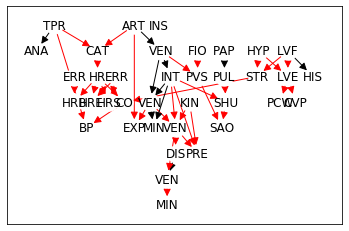

In [13]:
m.input_local_scores(local_scores_dict) # store the computed local scores dictionary
m.setParam('OutputFlag',True)
m.learn() # construct a MIP model and get Gurobi to solve it

Although this is quite a large network it is easy to see that ARTCO2 and KINKEDTUBE are indeed independent. This is because neither have any parents.

Gobnilp/Gurobi took quite a while (321 seconds) to find a provably optimal BN in this case (and recall that we are running with the default parent set limit of 3 - were we to raise that solving would take longer still). As is normal Gobnilp spent some time (here 73 seconds) adding cutting planes to reduce the upper bound on the score of an optimal BN from an original upper bound of -83626.171 down to -104594.63. Then Gurobi builds a search tree by branching on the values of MIP variables, finally finding a BN with a reasonable score at node 728 of this tree. Although at this point we know that the incumbent is close to the best possible BN (gap = 0.78%) it takes quite a while longer and thousands more search nodes before we can be sure we have an optimal BN. (In fact an optimal, as opposed to close-to-optimal BN, is not found until near the end of the search at node 13577.)

It is interesting to compare this to what happens when we learn from this dataset with *no extra constraints*:

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter PreCrush to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter CutPasses to 100000
   Prev: -1  Min: -1  Max: 2000000000  Default: -1
Changed value of parameter GomoryPasses to 100000
   Prev: -1  Min: -1  Max: 2000000000  Default: -1
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Changed value of parameter MIPGapAbs to 0.0
   Prev: 1e-10  Min: 0.0  Max: 1e+100  Default: 1e-10
Changed value of parameter PoolSolutions to 1
   Prev: 10  Min: 1  Max: 2000000000  Default: 10
Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 2304 rows, 7437 columns and 161370 nonzeros
Variable types: 0 continuous, 7437 integer (7437 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective

H  724   374                    -105290.3516 -104738.12  0.52%  92.6  106s
   727   376 -105275.85   22  159 -105290.35 -104738.12  0.52%  92.2  111s
   741   386 -105287.26   39  405 -105290.35 -104738.12  0.52%  90.5  116s
H  741   366                    -105278.2311 -104738.12  0.51%  90.5  117s
   746   369 -104858.14   12  393 -105278.23 -104738.12  0.51%  89.8  121s
   751   372 -104770.76    8  426 -105278.23 -104738.12  0.51%  89.3  126s
   752   373 -105271.59   33  416 -105278.23 -104738.12  0.51%  89.1  130s
   759   381 -104842.04   11  379 -105278.23 -104738.12  0.51%  97.0  135s
   801   394 -104761.94   19  284 -105278.23 -104761.94  0.49%   103  140s
H  837   378                    -105226.5119 -104816.72  0.39%   106  142s
   933   382 -105186.37   29   91 -105226.51 -104828.57  0.38%   109  146s
  1060   375 -105010.88   16  235 -105226.51 -104897.64  0.31%   112  150s
  1321   373     cutoff   18      -105226.51 -104981.06  0.23%   108  155s
  1577   368     cutoff  

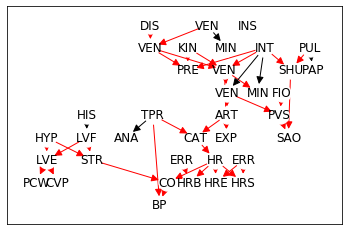

In [14]:
m2 = Gobnilp(gurobi_output=True)
m2.use_discrete_data('alarm_10000.dat')

Without the independence constraint solving takes 190 seconds (as opposed to 321 seconds), even though the set of allowed BNs is greater without the constraint. This is basically because Gobnilp is optimised for the case where the only constraint is that the BN is acyclic. 

The number of "Lazy constraints" posted in the two runs is worth examining: without the constraint there are only 8 but with the independence constraint there are 1153. This is because Gobnilp is adding constraints ruling out BNs (strictly speaking ancestral subgraphs of BNs) which do not satisfy the independence constraint. This is a crude method of enforcing (conditional) independence constraints and this adds to the slowness of solving.